In [1]:
#!pip install transformers
#!pip install datasets
#!pip install fastai
#!pip install ohmeow-blurr
#!pip install seqeval

# Skript3: Finetuning eines BERT-Modells für NER anhand von GermEval2014 mit FAST-AI
Dieses Notebook beschreibt das Training eines Transformer Modells für die Task des Named Entity Recognition. Es wird ein BERT-Modell mit der Fast-AI und der Blurr Bibliothek trainiert. Das Training erfolgt gemäß des Splits wie es die Shared Task 2014 vorgab.

Zunächst müssen die nötigen Bibliotheken importiert werden:

In [2]:
import pandas as pd
from fastai.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Anschließend werden die Skriptparameter gesetzt.  Die Variable `pretrained_model_name` beinhaltet den Namen des zu nutzenden vortrainierten Transformer Modells. Das Modell `deepset/gbert-base` ist ein BERT-Modell, welches mithilfe von deutschen Texten trainiert wurde. Der Name kann durch einen beliebigen Modellcheckpoint aus dem Transformers Model Hub ersetzt werden:  https://huggingface.co/models <br>
Die Batchsize für das Training wird mit der Variable `batch_size` gesetzt. Sollte es zu Out of Memory Fehlern kommen, dann sollte die Batchsize nach unten korrigiert werden.

In [3]:
pretrained_model_name = "deepset/gbert-base"
batch_size = 32

## Herunterladen des Datasets germeval2014

Neben der Transformers Bibliothek bietet die Hugging Face Inc. mit der `Datasets` Bibliothek eine Sammlung von Datensätzen und Metriken zum herunterladen an. Um diese zu nutzen, werden zuerst die beiden Methoden `load_dataset` und `load_metric` importiert.

In [4]:
from datasets import load_dataset, load_metric

Ebenso wie es für die vortrainierten Modelle einen Hub gibt, gibt es einen Hub für die verfügbaren Datasets: https://huggingface.co/datasets/germeval_14. Mit der Methode `load_dataset` kann das Dataset anschließend heruntergeladen werden.

In [5]:
dataset = load_dataset("germeval_14")

Reusing dataset germ_eval14 (/root/.cache/huggingface/datasets/germ_eval14/germeval_14/2.0.0/2a7a0c62dc3278203778c3a16bfbe257d5656aa0f4ad1e84f357f4caa904e0da)


#### Exploration des Aufbaus der Daten
Das heruntergeladene Dataset ist ein `DatasetDcit-Objekt`, welches die Keys `train, validation` und `test` besitzt. Der Value für jeden Key ist das `Dataset-Objekt`, welches die jeweiligen Daten für den Split enthält.

Im Falle des GermEval2014 Datasets bestehen die Daten aus insgesamt 31300 Datensätzen mit den Features `id, source, tokens, ner_tags` und `nested_ner_tags`. Die `nested_ner_tags` finden im Rahmen dieses Anwendungsbeispiels keine Verwendung.

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'tokens', 'ner_tags', 'nested_ner_tags'],
        num_rows: 24000
    })
    validation: Dataset({
        features: ['id', 'source', 'tokens', 'ner_tags', 'nested_ner_tags'],
        num_rows: 2200
    })
    test: Dataset({
        features: ['id', 'source', 'tokens', 'ner_tags', 'nested_ner_tags'],
        num_rows: 5100
    })
})

Möchte man auf ein einzelnes Item aus dem Datensatz zugreifen, so wählt man den Key des Splits aus wählt anschließend den Index des gewünschten Items aus:

In [7]:
print(dataset["train"][0])

{'id': '0', 'ner_tags': [19, 0, 0, 0, 7, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'nested_ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'source': 'n-tv.de vom 26.02.2005 [2005-02-26] ', 'tokens': ['Schartau', 'sagte', 'dem', '"', 'Tagesspiegel', '"', 'vom', 'Freitag', ',', 'Fischer', 'sei', '"', 'in', 'einer', 'Weise', 'aufgetreten', ',', 'die', 'alles', 'andere', 'als', 'überzeugend', 'war', '"', '.']}


Die NER Tags sind bereits Integer ID codiert:

In [8]:
dataset["train"][0]['ner_tags']

[19, 0, 0, 0, 7, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Das zugehörige Textlabel findet man unter dem features-Attribut des Datasets. Das Dataset GermEval2014 besitzt insgesamt 25 verschiedene Klassen:

In [9]:
dataset["train"].features["ner_tags"]

Sequence(feature=ClassLabel(num_classes=25, names=['O', 'B-LOC', 'I-LOC', 'B-LOCderiv', 'I-LOCderiv', 'B-LOCpart', 'I-LOCpart', 'B-ORG', 'I-ORG', 'B-ORGderiv', 'I-ORGderiv', 'B-ORGpart', 'I-ORGpart', 'B-OTH', 'I-OTH', 'B-OTHderiv', 'I-OTHderiv', 'B-OTHpart', 'I-OTHpart', 'B-PER', 'I-PER', 'B-PERderiv', 'I-PERderiv', 'B-PERpart', 'I-PERpart'], names_file=None, id=None), length=-1, id=None)

Die Klassenliste der Label kann wie folgt extrahiert werden:

In [10]:
label_list = dataset["train"].features['ner_tags'].feature.names
label_list

['O',
 'B-LOC',
 'I-LOC',
 'B-LOCderiv',
 'I-LOCderiv',
 'B-LOCpart',
 'I-LOCpart',
 'B-ORG',
 'I-ORG',
 'B-ORGderiv',
 'I-ORGderiv',
 'B-ORGpart',
 'I-ORGpart',
 'B-OTH',
 'I-OTH',
 'B-OTHderiv',
 'I-OTHderiv',
 'B-OTHpart',
 'I-OTHpart',
 'B-PER',
 'I-PER',
 'B-PERderiv',
 'I-PERderiv',
 'B-PERpart',
 'I-PERpart']

## Preprocessing der Daten

#### Herunterladen und Bereitstellen der Transformers Komponenten

Für die Konstruktion des Modells wird ein Label-ID Mapping erzeugt. Dieses Mapping wird anschließend in der Configuration des Modells hinterlegt. Es ermöglicht dem Modell die vorhergesagten Label als Texte auszugeben, anstatt ihrer numerischen Kodierung.

In [11]:
def build_config_kwargs(label_list):
    n_labels = len(label_list)
    #Aufbau id2label Mapping
    id2label = {}
    for i,l in enumerate(label_list):
        id2label[str(i)] = str(l)
    #Aufbau label2id mapping
    label2id = {}
    for i,l in enumerate(label_list):
        label2id[str(l)] = str(i)
    return {
        "num_labels" : n_labels,
        "id2label": id2label,
        "label2id": label2id
    }

config_kwargs = build_config_kwargs(label_list)
config_kwargs

{'id2label': {'0': 'O',
  '1': 'B-LOC',
  '10': 'I-ORGderiv',
  '11': 'B-ORGpart',
  '12': 'I-ORGpart',
  '13': 'B-OTH',
  '14': 'I-OTH',
  '15': 'B-OTHderiv',
  '16': 'I-OTHderiv',
  '17': 'B-OTHpart',
  '18': 'I-OTHpart',
  '19': 'B-PER',
  '2': 'I-LOC',
  '20': 'I-PER',
  '21': 'B-PERderiv',
  '22': 'I-PERderiv',
  '23': 'B-PERpart',
  '24': 'I-PERpart',
  '3': 'B-LOCderiv',
  '4': 'I-LOCderiv',
  '5': 'B-LOCpart',
  '6': 'I-LOCpart',
  '7': 'B-ORG',
  '8': 'I-ORG',
  '9': 'B-ORGderiv'},
 'label2id': {'B-LOC': '1',
  'B-LOCderiv': '3',
  'B-LOCpart': '5',
  'B-ORG': '7',
  'B-ORGderiv': '9',
  'B-ORGpart': '11',
  'B-OTH': '13',
  'B-OTHderiv': '15',
  'B-OTHpart': '17',
  'B-PER': '19',
  'B-PERderiv': '21',
  'B-PERpart': '23',
  'I-LOC': '2',
  'I-LOCderiv': '4',
  'I-LOCpart': '6',
  'I-ORG': '8',
  'I-ORGderiv': '10',
  'I-ORGpart': '12',
  'I-OTH': '14',
  'I-OTHderiv': '16',
  'I-OTHpart': '18',
  'I-PER': '20',
  'I-PERderiv': '22',
  'I-PERpart': '24',
  'O': '0'},
 'num_la

Anschließend wird lediglich der gewünschte model_checkpoint an die Methode `BLURR_MODEL_HELPER.get_hf_objects` übergeben. Diese beschafft das entsprechende Model und die zugehörigen Daten wie den Tokenizer für die gewählte Task:

In [12]:
task = HF_TASKS_AUTO.TokenClassification
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task = task,
                                                                               config_kwargs = config_kwargs )

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bert',
 transformers.models.bert.configuration_bert.BertConfig,
 transformers.models.bert.tokenization_bert_fast.BertTokenizerFast,
 transformers.models.bert.modeling_bert.BertForTokenClassification)

Das heruntergeladene Modell besitzt die BERT-Architektur mit einem aufgesetzten Tokenklassifizierungskopf mit 25 Klassen

## Erstellen der Dataloader via DataBlock API
Um das Dataset für die Verwendung mit der Blurr Bibliothek vorzubereiten, müssen die `ner_tags` pro Token als seperates `labels` Feature vorliegen. Dafür wird die folgende `decode_labels` Funktion definiert. Sie liest der `ner_tags` eines Datensatzes und decodiert diese in in ihre Stringrepräsentation mithilfe der `label_list`.

In [13]:
def decode_labels(data):
  labels = []
  for i, label in enumerate(data["ner_tags"]):
    label_decoded = label_list[label]
    labels.append(label_decoded)
  data["labels"] = labels
  return data

Die Funktion kann mithilfe der `map` Funktion des Dataset-Objekts auf das gesamte Dataset angewandt werden:

In [14]:
dataset= dataset.map(decode_labels)

Loading cached processed dataset at /root/.cache/huggingface/datasets/germ_eval14/germeval_14/2.0.0/2a7a0c62dc3278203778c3a16bfbe257d5656aa0f4ad1e84f357f4caa904e0da/cache-46f268e495839840.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/germ_eval14/germeval_14/2.0.0/2a7a0c62dc3278203778c3a16bfbe257d5656aa0f4ad1e84f357f4caa904e0da/cache-bd0ea2198769ccbd.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/germ_eval14/germeval_14/2.0.0/2a7a0c62dc3278203778c3a16bfbe257d5656aa0f4ad1e84f357f4caa904e0da/cache-5ede5ef2ea73cafa.arrow


Anschließend kann aus dem Dataset ein `Pandas Dataframe` erzeugt werden:
 - Es wird für jeden Split ein `DataFrame` erzeugt.
 - Anschließend werden Trainings und Validierungsset zu einem DataFrame zusammengefügt. Um die Daten auseinander zu halten, wird eine Spalte `is_valid` eingefügt, welche die Daten des Validierungsset markiert.

In [15]:
df_train = pd.DataFrame(dataset['train'])
# Fügt eine Spalte is_valid ein die eine Zeile makiert als Teil des Validationsets
df_train['is_valid'] = False
df_valid = pd.DataFrame(dataset['validation'])
# Fügt eine Spalte is_valid ein die eine Zeile makiert als Teil des Validationsets
df_valid['is_valid'] = True
df_train_valid = df_train.append(df_valid)
df_train_valid

,id,labels,ner_tags,nested_ner_tags,source,tokens,is_valid
0,0,"[B-PER, O, O, O, B-ORG, O, O, O, O, B-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[19, 0, 0, 0, 7, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",n-tv.de vom 26.02.2005 [2005-02-26],"[Schartau, sagte, dem, "", Tagesspiegel, "", vom, Freitag, ,, Fischer, sei, "", in, einer, Weise, aufgetreten, ,, die, alles, andere, als, überzeugend, war, "", .]",False
1,1,"[O, B-PER, I-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O]","[0, 19, 20, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",welt.de vom 29.10.2005 [2005-10-29],"[Firmengründer, Wolf, Peter, Bree, arbeitete, Anfang, der, siebziger, Jahre, als, Möbelvertreter, ,, als, er, einen, fliegenden, Händler, aus, dem, Libanon, traf, .]",False
2,2,"[O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O, O, O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",http://www.stern.de/sport/fussball/krawalle-in-der-fussball-bundesliga-dfb-setzt-auf-falsche-konzepte-1553657.html#utm_source=standard&utm_medium=rss-feed&utm_campaign=sport [2010-03-25],"[Ob, sie, dabei, nach, dem, Runden, Tisch, am, 23., April, in, Berlin, durch, ein, pädagogisches, Konzept, unterstützt, wird, ,, ist, allerdings, zu, bezweifeln, .]",False
3,3,"[B-ORG, I-ORG, O, O, O, O, O, O, O, O, O, B-LOCderiv, O, O]","[7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",stern.de vom 21.03.2006 [2006-03-21],"[Bayern, München, ist, wieder, alleiniger, Top-, Favorit, auf, den, Gewinn, der, deutschen, Fußball-Meisterschaft, .]",False
4,4,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",http://www.fr-online.de/in_und_ausland/sport/aktuell/1618625_Frings-schaut-finster-in-die-Zukunft.html [2008-10-24],"[Dabei, hätte, der, tapfere, Schlussmann, allen, Grund, gehabt, ,, sich, viel, früher, aufzuregen, .]",False
...,...,...,...,...,...,...,...
2195,2195,"[O, B-ORGpart, B-ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[0, 11, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",spiegel.de vom 02.07.2005 [2005-07-02],"[Der, BMW-Kleinwagen-Ableger, Mini, versucht, es, mit, jetzt, mit, drei, Sondermodellen, ,, die, trendbewusste, Kunden, ansprechen, sollen, .]",True
2196,2196,"[O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","http://www.np-coburg.de/nachrichten/lokal/co-land/coburgland/art2400,780155.html [2011-01-19]","[Denn, Arbeiter, sind, auch, vernünftig, !]",True
2197,2197,"[O, O, O, O, O, O, O, O, B-OTH, I-OTH, O, O, O, O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 13, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",http://de.wikipedia.org/wiki/James_Clerk_Maxwell [2009-12-28],"[Er, entwickelte, einen, Satz, von, Gleichungen, (, die, Maxwellschen, Gleichungen, ), ,, welche, die, Grundlagen, der, Elektrizitätslehre, und, des, Magnetismus, bilden, .]",True
2198,2198,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",http://www.haz.de/Hannover/Aus-der-Region/Am-Deister/Wennigsen/Fahrerin-faehrt-mit-Audi-in-Rotte-Wildschweine.html [2011-01-07],"[Ps, ., Schauen, Sie, sich, das, Foto, einmal, richtig, an, ,, wie, soll, man, da, rechtzeitig, eine, Wildschweinrotte, sehen, ?]",True


Für das Testset wird ein seperater `DataFrame` erzeugt, um später einen separaten `DataLoader` für dieses Dataset erzeugen zu können.

In [16]:
df_test = pd.DataFrame(dataset['test'])
# Fügt eine Spalte is_valid ein die eine Zeile makiert als Teil des Validationsets
df_test["is_valid"] = True
dummy_row ={"labels":["O"],"tokens":"Dummy","is_valid": False}
# Einfügen der Dummyzeile, sodass im Anschluss im DataBlock der ColSplitter verwendet werden kann 
# und das Testset komplett ist
df_test = df_test.append(dummy_row,ignore_index=True)
df_test.tail()

,id,labels,ner_tags,nested_ner_tags,source,tokens,is_valid
5096,5096,"[O, O, O, O, O, O, O, O, O, B-PER, O, O, O, O, O, O, B-PER, O, O, O, O, B-PER, I-PER, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 19, 20, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",http://de.wikipedia.org/wiki/Kirche_Maria_Himmelfahrt_(Frauenau) [2009-09-28],"[Der, rechte, Seitenaltar, zeigt, den, Tod, des, Hl, ., Josef, und, seitlich, die, Figuren, der, Apostel, Simon, (, links, ), und, Judas, Thaddäus, (, rechts, ), .]",True
5097,5097,"[B-ORG, I-ORG, I-ORG, O]","[7, 8, 8, 0]","[3, 0, 0, 0]",http://de.wikipedia.org/wiki/Münchner_Neueste_Nachrichten [2010-01-09],"[Münchner, Neueste, Nachrichten, .]",True
5098,5098,"[B-LOC, B-ORGpart, B-PER, I-PER, O, O, O, O, O, B-PER, O, O, O, O, O, O, B-PER, O, O, O, O, O]","[1, 11, 19, 20, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",archiv.tagesspiegel.de vom 15.09.2005 [2005-09-15],"[Hessens, CDU-Regierungschef, Roland, Koch, gab, rasch, zu, Protokoll, ,, Merkels, Glaubwürdigkeit, hänge, an, ihrer, Zusage, ,, Kirchhof, das, Finanzressort, zu, übertragen, .]",True
5099,5099,"[O, O, O, O, O, O, O, O, O, O, O, O, B-PER, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",http://de.wikipedia.org/wiki/Victor_Gardthausen [2009-11-12],"[Nachdem, er, 1907, nicht, zum, Direktor, der, Bibliothek, berufen, wurde, ,, verließ, Gardthausen, den, Bibliotheksdienst, .]",True
5100,NaN,[O],NaN,NaN,NaN,Dummy,False


Um die Trainingsdaten in das Modell zu füttern, wird in Fast-AI ein DataLoader benötigt. Dieser kann mit der DataBlock API erstellt werden. Hierfür übergibt man dem Konstruktur die entsprechenden Blöcke und Informationen darüber, wie die x und y Variable aus den Datensätzen zu ermitteln sind.<br>

Der `HF_TextBlock` wird verwendet, weil die x-Variable rohem Text entspricht. Der Block kümmert sich um die Anreicherung und Tokenisierung der Eingabedaten des Modells. Dafür wird automatisch der zugehörige Tokenizer der Transformerarchitektur verwendet. Blöcke können Transformationsoperationen auf die Eingabedaten durchführen. Die hier verwendete `HF_TokenClassBeforeBatchTransform` kümmert sich automatisch um alle was nötig ist, um einen Minibatch zu erstellen. Zum Beispiel werden die Inputtoken via Subwordtokenisierung tokenisiert und die Nebenprodukte des Tokenisierungsprozesses wie zum Beipsiel die `attention_mask` werden für das Modell vorbereitet. 

Der zweite Block bestimmt die Natur der y-Variable. Da es sich hier um ein Tokenklassifizierungsproblem handelt, wird der `HF_TokenCategoryBlock` verwendet. Dieser wandelt die Inhalte der `labels` Spalte automatisch in entsprechende Kategorieencodings um. Als Vokabular wird die Liste der Tokenklassen verwendet<br>


In [17]:
before_batch_tfm = HF_TokenClassBeforeBatchTransform(hf_arch,hf_config,hf_tokenizer,hf_model,
                                                     is_split_into_words=True,
                                                     ignore_token_id=-100,
                                                     # exkludiert die Special Tokens in der Loss Berechnung
                                                     tok_kwargs={ 'return_special_tokens_mask': True })

In [18]:
blocks = ( HF_TextBlock(before_batch_tfm=before_batch_tfm, input_return_type=HF_TokenClassInput), 
          HF_TokenCategoryBlock(vocab=label_list))

Nachdem die Blöcke für den Datablock erstellt wurden, kann anschließend der `DataBlock` konstruiert werden. Dabei handelt es sich um eine Art Blaupause wie `Dataloader` aus Datasets zu erstellen sind. Dieser erhält die Blöcke sowie die Parameter `get_x` und `get_y` im Konstruktoraufruf. Durch die Parameter `get_x` und `get_y` kann dem `DataBlock` mitgeteilt werden, wie er die x- und y-Variable aus dem später übergebenen `DataFrame` beschaffen soll. In diesem Fall wird für die Funktion `get_x` ein `ColReader` genutzt, welcher die entsprechenden Werte aus der Spalte `tokens`  extrahiert.<br>

Da es sich hier um ein Tokenklassifizierungsproblem handelt und Transformer Modelle Subword Tokenisierung benutzen, kommt es häufig dazu, dass es mehr tokenisierte `input_ids` gibt als vorhandene `ner_tags` (siehe Skript1 und 2). Dies ist ein Allignmentproblem, welches bei Tokenklassifizierungsanwendungen auftritt. So kann beispielweise das Wort `"vierwöchig"` die 3 Subtwort Token `"vier", "##wöch", "##ig"` ergeben. Gleichzeitig würde für das Wort `"vierwöchig"` nur ein `ner_tag` vorliegen. Um das Problem zu lösen wird die `get_y` Funktion wie folgt definiert:
 - Sie gibt das Label sowie die Anzahl der Subword-Token pro Token zurück

In [19]:
def get_y(input):
    return [ (label, len(hf_tokenizer.tokenize(str(token)))) for token, label in zip(input.tokens, input.labels) ]

Der `splitter` Parameter bestimmt, wie der Datensatz aufgeteilt werden soll. Der gewählte Splitter ist der `ColSplitter`. Dieser nutzt die im `DataFrame` eingefügte Spalte `is_valid` und teilt die Daten entsprechend dem Trainings und dem Validierungsset zu:

In [20]:
dblock = DataBlock(blocks=blocks,
                               get_x=ColReader('tokens'), 
                               get_y=get_y,
                               splitter=ColSplitter())

Mithilfe der `summary` Methode kann man einen Problelauf des DataBlock starten. Die Ausgabe gibt Auskünfte darüber, was während der Verabeitung der Daten passiert und ob es zu Fehlern kommt.

In [21]:
dblock.summary(df_train_valid)

Setting-up type transforms pipelines
0        0  ...    False
1        1  ...    False
2        2  ...    False
3        3  ...    False
4        4  ...    False
...    ...  ...      ...
2195  2195  ...     True
2196  2196  ...     True
2197  2197  ...     True
2198  2198  ...     True
2199  2199  ...     True

[26200 rows x 7 columns]
Found 26200 items
2 datasets of sizes 24000,2200
Setting up Pipeline: ColReader -- {'cols': 'tokens', 'pref': '', 'suff': '', 'label_delim': None}
Setting up Pipeline: get_y -> HF_TokenCategorize

Building one sample
  Pipeline: ColReader -- {'cols': 'tokens', 'pref': '', 'suff': '', 'label_delim': None}
    starting from
      id                                                                                                                                                                               0
labels                                                                                     [B-PER, O, O, O, B-ORG, O, O, O, O, B-PER, O, O, O, O, O, O, O

Ganz unten in der Ausgabe kann man lesen, dass 2 Datasets erstellt werden mit 24000 und 2200 Einträgen. Dies entspricht genau dem Split des GermEval2014 Datasets.

Im Anschluss kann der `DataLoader` für die Trainingsdaten erzeugt werden. 
Dafür ruft man die `dataloaders` Methode des erzeugten `DataBlocks` auf und übergibt den `DataFrame` und die Batchsize für den genutzten Datensatz.
Die verwendete Batch Size liegt bei 32 aufgrund der begrenzten Speicherkapazitäten der verwendeten GPU.

In [22]:
dls_train_valid = dblock.dataloaders(df_train_valid, bs=batch_size)

Wie mit jedem `DataLoader` in Fast-AI kann auch hier ein Beispiel Batch visualisiert werden. Dies wird mit der Methode `show_batch` gestartet.

In [23]:
dls_train_valid.show_batch(dataloaders=dls_train_valid,max_n=3)

,token / target label
0,"[('Andere', 'O'), ('Albumtitel', 'O'), ('sind', 'O'), ('an', 'O'), ('bekannte', 'O'), ('Begriffe', 'O'), ('angelehnt', 'O'), (':', 'O'), ('Fettes', 'B-OTH'), ('Brot', 'I-OTH'), ('für', 'I-OTH'), ('die', 'I-OTH'), ('Welt', 'I-OTH'), ('(', 'O'), ('Brot', 'O'), ('für', 'O'), ('die', 'O'), ('Welt', 'O'), ('),', 'O'), ('Auf', 'O'), ('einem', 'B-OTH'), ('Auge', 'I-OTH'), ('blöd', 'I-OTH'), ('(', 'I-OTH'), ('„', 'O'), ('Auf', 'O'), ('einem', 'O'), ('Auge', 'O'), ('blind', 'O'), ('“', 'O'), ('),', 'O'), ('Am', 'O'), ('Wasser', 'O'), ('gebaut', 'B-OTH'), ('(', 'I-OTH'), ('„', 'I-OTH'), ('Nah', 'O'), ('am', 'O'), ('Wasser', 'O'), ('gebaut', 'O'), ('“', 'O'), (')', 'O'), ('und', 'O'), ('Strom', 'O'), ('und', 'O'), ('Drang', 'B-OTH'), ('(', 'I-OTH'), ('„', 'I-OTH'), ('Sturm', 'O'), ('und', 'O'), ('Drang', 'B-OTH'), ('“', 'I-OTH'), (').', 'I-OTH')]"
1,"[('Allerdings', 'O'), ('ist', 'O'), ('im', 'O'), ('RFC', 'O'), ('5321', 'O'), ('auch', 'O'), ('die', 'O'), ('maximale', 'O'), ('Länge', 'O'), ('des', 'O'), ('""', 'O'), ('Path', 'O'), ('""', 'O'), ('-', 'O'), ('Elements', 'O'), ('definiert,', 'O'), ('das', 'O'), ('die', 'O'), ('Elemente', 'O'), ('""', 'O'), ('FROM', 'O'), ('""', 'O'), ('und', 'O'), ('""', 'O'), ('RCPT', 'O'), ('TO', 'O'), ('""', 'O'), ('im', 'O'), ('Envelope', 'O'), ('bestimmt', 'O'), ('und', 'O'), ('die', 'O'), ('maximale', 'O'), ('Länge', 'O'), ('von', 'O'), ('Oktetten', 'O'), ('einschließlich', 'O'), ('der', 'O'), ('Separatoren', 'O'), ('""', 'O'), ('&', 'O'), ('lt', 'O'), (';', 'O'), ('""', 'O'), ('und', 'O'), ('""', 'O'), ('>', 'O'), ('""', 'O')]"
2,"[('1998', 'O'), ('/', 'O'), ('1999', 'O'), ('nahm', 'O'), ('das', 'O'), ('Duo', 'O'), ('an', 'O'), ('drei', 'O'), ('Festivals', 'O'), ('und', 'O'), ('Wettbewerben', 'O'), ('teil', 'B-OTH'), (':', 'I-OTH'), ('Zukunft', 'I-OTH'), ('der', 'O'), ('Ukraine', 'B-OTH'), ('(,', 'I-OTH'), ('1998', 'O'), ('),', 'O'), ('Melodija', 'O'), ('(,', 'O'), ('1998', 'B-OTH'), ('in', 'O'), ('Lemberg', 'B-OTH'), (')', 'O'), ('sowie', 'O'), ('Perlen', 'O'), ('der', 'B-LOC'), ('Saison', 'O'), ('(,', 'O'), ('1999', 'B-OTH'), ('),', 'I-OTH'), ('wo', 'I-OTH'), ('sie', 'O'), ('ihre', 'B-OTH'), ('ersten', 'I-OTH'), ('drei', 'O'), ('Stücke', 'O'), ('spielten.', 'O')]"


Ein Batch besteht dem Output zufolge aus einer Reihe von Tuple, welche jeweils aus dem Token und dem zugehörigen Tokenlabel bestehen.

Der gleiche `DataBlock` kann für die Erzeugung des `DataLoaders` für das Testset genutzt werden:

In [24]:
dls_test = dblock.dataloaders(df_test, bs=batch_size)

In [25]:
dls_test.valid.show_batch(dataloaders=dls_test,max_n=2)

,token / target label
0,"[('Auf', 'O'), ('das', 'O'), ('gesamte', 'O'), ('County', 'O'), ('bezogen', 'O'), ('setzte', 'O'), ('sich', 'O'), ('die', 'O'), ('Bevölkerung', 'O'), ('zusammen', 'O'), ('aus', 'O'), ('25,', 'O'), ('30', 'O'), ('%', 'O'), ('Einwohnern', 'O'), ('unter', 'O'), ('18', 'O'), ('Jahren,', 'O'), ('9,', 'O'), ('10', 'O'), ('%', 'O'), ('zwischen', 'O'), ('18', 'O'), ('und', 'O'), ('24', 'O'), ('Jahren,', 'O'), ('29,', 'O'), ('40', 'O'), ('%', 'O'), ('zwischen', 'O'), ('25', 'O'), ('und', 'O'), ('44', 'O'), ('Jahren,', 'O'), ('23,', 'O'), ('70', 'O'), ('%', 'O'), ('zwischen', 'O'), ('45', 'O'), ('und', 'O'), ('64', 'O'), ('Jahren', 'O'), ('und', 'O'), ('12,', 'O'), ('50', 'O'), ('%', 'O'), ('waren', 'O'), ('65', 'O'), ('Jahre', 'O'), ('alt', 'O'), ('oder', 'O')]"
1,"[('Essen', 'O'), ('im', 'O'), ('Restaurant', 'O'), (':', 'O'), ('Fisch', 'O'), ('ist', 'O'), ('teurer', 'O'), ('als', 'O'), ('Fleisch,', 'O'), ('ca.', 'O'), ('175', 'O'), ('Q,', 'O'), ('Fleisch', 'O'), ('120', 'O'), ('Q,', 'O'), ('Palmherzensalat', 'O'), ('55', 'O'), ('Q,', 'O'), ('Flasche', 'O'), ('Wein', 'O'), ('120', 'O'), ('Q,', 'O'), ('Bier', 'O'), ('18', 'O'), ('Q,', 'O'), ('Wasser', 'O'), ('5', 'O'), ('Q,', 'O'), ('Cuba', 'O'), ('libre', 'O'), ('20', 'O'), ('Q.', 'O'), ('Die', 'O'), ('Preise', 'O'), ('sind', 'O'), ('auch', 'O'), ('in', 'O'), ('guten', 'O'), ('Hotels', 'O'), ('günstig.', 'O')]"


#### Exploration der verarbeiteten Daten

Wie sehen nun die Daten aus, die das Modell füttern? Das kann herausgefunden werden, indem man sich vom `DataLoader` einen Batch geben lässt:

In [26]:
b = dls_train_valid.one_batch()
b

({'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
  'input_ids': tensor([[  102,  6879,  4597,  ...,     0,     0,     0],
          [  102,  2311,   288,  ...,     0,     0,     0],
          [  102,  2445,  1250,  ...,     0,     0,     0],
          ...,
          [  102,   465,   893,  ...,     0,     0,     0],
          [  102, 11214,   371,  ...,     0,     0,     0],
          [  102,   347,  2701,  ...,     0,     0,     0]], device='cuda:0'),
  'special_tokens_mask': tensor([[1, 0, 0,  ..., 1, 1, 1],
          [1, 0, 0,  ..., 1, 1, 1],
          [1, 0, 0,  ..., 1, 1, 1],
          ...,
          [1, 0, 0,  ..., 1, 1, 1],
          [1, 0, 0,  ..., 1, 1, 1],
          [1, 0, 0,  ..., 1, 1, 1]], device='cuda:0'),
  'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0]

In [27]:
len(b),len(b[0]['input_ids']), b[0]['input_ids'].shape, len(b[1]) 

(2, 32, torch.Size([32, 71]), 32)

Man sieht den klassischen Aufbau des Inputs. Dieser besteht aus den `input_ids`, den `token_type_ids`, der `attention_mask`, der `special_token_mask` und TokenTensorKategorien für das y-Label. Auch hier ist die gewählte Batchsize von 32 erkennbar, denn es liegen für jedes Attribut von `b` 32 Listen oder Werte vor. Jede ergibt einen zusammengehörigen Datensatz.

Mithilfe der `input_ids` und dem `hf_tokenizer` können die Tensoren ebenfalls wieder in ihre Textform decodiert werden:
- Es ist erkennbar, dass die BERT typischen Special Tokens nun in der Sequenz enthalten sind
- Ebenfalls wurden bei Bedarf Padding Tokens eingefügt

In [28]:
hf_tokenizer.decode(b[0]['input_ids'][1])

'[CLS] Denn es hat ja europäische Juden gegeben - nicht viele, aber doch ein paar -, die den Völkermord überlebten, indem sie sich als Christen ausgaben : Kinder, die das " Sch\'ma Jisrael " vergessen und statt dessen das " Vater unser " lernen mußten. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

## Finetuning des Modells

Es kann nun der Fast-AI `Learner` erzeugt werden. Für die Kompatibilität mit der Transformer Architektur muss das Modell mit dem `HF_BaseModelWrapper` gewrappt werden. Dem `Learner` wird der Trainings-DataLoader, die Modellarchitektur, die Optimierungsfunktion, die Lossfunktion, die zu berechnenden Metriken sowie für die Kompatibilität noch Callbacks und ein Modellsplitter aus der Blurr Bibliothek übergeben.

In [29]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]

learn = Learner(dls_train_valid,
                model,
                opt_func=partial(Adam),
                cbs=learn_cbs,
                splitter=hf_splitter)

learn.create_opt() # -> Erzeugt die Layer Gruppen basierend auf der "splitter" Funktion
# Einfrieren des Modells bis auf den finalen Layer
learn.freeze()

Mit der Methode `learn.blurr_summary()` kann man sich eine Zusammenfassung zum Modell anschauen. Der Bericht enthält Informationen zum Aufbau des Modells sowie über die Anzahl der Parameter und ob diese trainierbar sind. Da das Modell gefroren wurde kann nur der finale Layer sowie die LayerNorm der darunter liegenden Layer trainiert werden.

In [30]:
learn.blurr_summary()

HF_BaseModelWrapper (Input shape: 32 x 69)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 69 x 768       
Embedding                                 23886336   False     
Embedding                                 393216     False     
Embedding                                 1536       False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
      

Der Report zeigt das im eingefrorenen Zustand nur 57625 von 109356313 Parametern trainiert werden. 

#### Finden einer guten Learning Rate
Durch die Integration mit Fast-AI kann nun auch der integrierte Learning Rate Finder genutzt werden:

0.005754399299621582

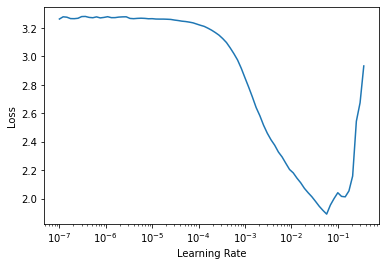

In [31]:
lr_min, _ = learn.lr_find(suggestions=True)
lr_min

Der Punkt mit dem kleinsten Loss-Wert liegt bei ca. 0.06. Der Lerning Rate Finder gibt ausgehend von diesem Punkt einen Vorschlag der eine Größenordnung kleiner ist. Der vorgeschlagene Wert liegt demnach beim Wert 6E-3. Dieser Punkt liegt im dargestellten Graphen in der Abwärtsbewegung und ist demnach gut geeignet.

Um die Metriken Accuracy, Precision, Recall, and F1 zu mit der `seqeval` Bibliothek zu berechnen kann der folgende Trainingscallback genutzt werden:

In [32]:
fit_cbs = [HF_TokenClassMetricsCallback()]

Anschließend kann das Training über die `fit_one_cycle` Methode gestartet werden. <br>
Hierfür wird zunächst nur der oberste Layer des Modells trainiert, da die anderen eingefroren wurden.

In [33]:
learn.fit_one_cycle(1, lr_max= lr_min, cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.072765,0.065290,0.978969,0.844428,0.802702,0.823036,02:31


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Nach nur einer Epoch konnte eine Accuracy von 97,89% erreicht werden.

Über das `Learner` Objekt kann man sich anschließend ein paar Beispielvorhersagen anzeigen lassen:

In [34]:
learn.show_results(learner=learn)

,token / target label / predicted label
0,"[('Darüber', 'O', 'O'), ('hinaus', 'O', 'O'), ('produziert', 'O', 'O'), ('der', 'O', 'O'), ('hr', 'B-ORG', 'O'), ('allein', 'O', 'B-ORG'), ('oder', 'O', 'O'), ('federführend', 'O', 'O'), ('mit', 'O', 'O'), ('anderen', 'O', 'O'), ('Landesrundfunkanstalten', 'O', 'O'), ('für', 'O', 'O'), ('Das', 'B-ORG', 'O'), ('Erste', 'I-ORG', 'O'), ('Reportagen', 'O', 'O'), ('und', 'O', 'O'), ('Dokumentationen', 'O', 'O'), ('wie', 'O', 'O'), ('„', 'O', 'O'), ('ARD', 'B-OTH', 'B-ORG'), ('-', 'O', 'I-ORG'), ('exclusiv', 'O', 'O'), ('“,', 'O', 'O'), ('„', 'B-OTH', 'O'), ('Der', 'I-OTH', 'O'), ('Tag,', 'I-OTH', 'O'), ('als', 'I-OTH', 'O'), ('“,', 'I-OTH', 'O'), ('„', 'O', 'B-ORG'), ('Das', 'O', 'I-OTH'), ('rote', 'O', 'I-OTH'), ('Quadrat', 'B-OTH', 'I-OTH'), ('“', 'I-OTH', 'I-OTH'), ('und', 'I-OTH', 'I-OTH'), ('die', 'O', 'O'), ('Serien', 'O', 'O'), ('„', 'O', 'O'), ('Unsere', 'O', 'B-OTH'), ('50er', 'O', 'I-OTH'), ('Jahre', 'B-OTH', 'I-OTH'), ('“', 'I-OTH', 'I-OTH'), ('und', 'I-OTH', 'I-OTH'), ('„', 'O', 'O'), ('Unsere', 'O', 'O'), ('60er', 'O', 'O'), ('Jahre', 'B-OTH', 'B-OTH'), ('“.', 'I-OTH', 'I-OTH')]"
1,"[('Jetzt', 'O', 'O'), ('noch', 'O', 'O'), ('Gleichgesinnte', 'O', 'O'), ('treffen,', 'O', 'O'), ('das', 'O', 'O'), ('wäre', 'O', 'O'), ('ein', 'O', 'O'), ('sauberer', 'O', 'O'), ('Abschluss', 'O', 'O'), ('und', 'O', 'O'), ('dort', 'O', 'O'), ('sind', 'O', 'O'), ('sie', 'O', 'O'), (':', 'O', 'O'), ('Eva', 'O', 'O'), ('Brylka', 'O', 'O'), ('(', 'B-PER', 'O'), ('24', 'I-PER', 'O'), ('),', 'O', 'O'), ('Ragnar', 'O', 'O'), ('Dam', 'O', 'B-PER'), ('(', 'O', 'I-PER'), ('26', 'B-PER', 'I-PER'), (')', 'I-PER', 'I-PER'), ('und', 'O', 'O'), ('Christoph', 'O', 'O'), ('Ellebrecht', 'O', 'O'), ('(', 'O', 'O'), ('25', 'B-PER', 'B-PER'), ('),', 'I-PER', 'I-PER'), ('Studenten', 'O', 'I-PER'), ('aus', 'O', 'I-PER'), ('Lübeck,', 'O', 'O'), ('haben', 'O', 'O'), ('sich', 'O', 'O'), ('in', 'O', 'O'), ('Gelb', 'B-LOC', 'B-PER'), ('und', 'O', 'I-PER'), ('mit', 'O', 'I-PER'), ('Flugblättern', 'O', 'I-PER'), ('auf', 'O', 'O'), ('nach', 'O', 'O'), ('Kiel', 'O', 'O'), ('gemacht.', 'O', 'O')]"
2,"[('Nach', 'O', 'O'), ('Zuspiel', 'O', 'O'), ('von', 'O', 'O'), ('Wayne', 'B-PER', 'O'), ('Rooney,', 'I-PER', 'O'), ('der', 'O', 'B-PER'), ('am', 'O', 'I-PER'), ('Samstag', 'O', 'I-PER'), ('seinen', 'O', 'O'), ('Vertrag', 'O', 'O'), ('bei', 'O', 'O'), ('ManU', 'O', 'O'), ('vorzeitig', 'B-ORG', 'O'), ('bis', 'O', 'O'), ('2012', 'O', 'O'), ('verlängert', 'O', 'B-ORG'), ('hatte,', 'O', 'I-ORG'), ('brachte', 'O', 'O'), ('der', 'O', 'O'), ('Franzose', 'O', 'O'), ('Louis', 'O', 'O'), ('Saha', 'B-LOCderiv', 'O'), ('(', 'B-PER', 'O'), ('29.', 'I-PER', 'O'), (')', 'O', 'O'), ('die', 'O', 'B-LOCderiv'), ('in', 'O', 'B-LOCderiv'), ('der', 'O', 'B-PER'), ('ersten', 'O', 'I-PER'), ('Halbzeit', 'O', 'I-PER'), ('klar', 'O', 'O'), ('besseren', 'O', 'O'), ('""', 'O', 'O'), ('Red', 'O', 'O'), ('Devils', 'O', 'O'), ('""', 'B-ORG', 'O'), ('vor', 'I-ORG', 'O'), ('76', 'O', 'O'), ('000', 'O', 'O'), ('Zuschauern', 'O', 'O'), ('in', 'O', 'O'), ('Old', 'O', 'O'), ('Trafford', 'O', 'B-ORG'), ('in', 'B-LOC', 'I-ORG'), ('Führung.', 'I-LOC', 'I-ORG')]"
3,"[('Das', 'O', 'O'), ('zweite', 'O', 'O'), ('Thema', 'O', 'O'), ('(', 'O', 'O'), ('eher', 'O', 'O'), (':', 'O', 'O'), ('Motiv', 'O', 'O'), (')', 'O', 'O'), ('folgt', 'O', 'O'), ('–', 'O', 'O'), ('wie', 'O', 'O'), ('im', 'O', 'O'), ('1.', 'O', 'O'), ('Satz', 'O', 'O'), ('–', 'O', 'O'), ('ohne', 'O', 'O'), ('Zäsur', 'O', 'O'), ('ab', 'O', 'O'), ('Takt', 'O', 'O'), ('34.', 'O', 'O'), ('Es', 'O', 'O'), ('besteht', 'O', 'O'), ('aus', 'O', 'O'), ('einer', 'O', 'O'), ('zweitaktigen', 'O', 'O'), ('ab', 'O', 'O'), ('-', 'O', 'O'), ('auf', 'O', 'O'), ('–', 'O', 'O'), ('Bewegung', 'O', 'O'), ('von', 'O', 'O'), ('1.', 'O', 'O'), ('Violine', 'O', 'O'), ('und', 'O', 'O'), ('Bass', 'O', 'O'), ('im', 'O', 'O'), ('Dialog,', 'O', 'O'), ('wobei', 'O', 'O'), ('die', 'O', 'O'), ('2.', 'O', 'O'), ('Violine', 'O', 'O'), ('mit', 'O', 'O'

Um die genauen Ergebnisse pro Tokenklasse zu ermitteln kann der integrierte `token_classification_report` verwendet werden:

In [35]:
print(learn.token_classification_report)

              precision    recall  f1-score   support

         LOC       0.92      0.89      0.90       791
    LOCderiv       0.89      0.86      0.87       243
     LOCpart       0.46      0.80      0.59        30
         ORG       0.82      0.68      0.75       599
    ORGderiv       0.00      0.00      0.00         0
     ORGpart       0.74      0.74      0.74        90
         OTH       0.64      0.59      0.61       292
    OTHderiv       0.62      0.53      0.57        19
     OTHpart       0.22      0.57      0.32         7
         PER       0.93      0.89      0.91       737
    PERderiv       0.00      0.00      0.00         0
     PERpart       0.22      0.80      0.35         5

   micro avg       0.84      0.80      0.82      2813
   macro avg       0.54      0.61      0.55      2813
weighted avg       0.85      0.80      0.83      2813



#### Trainieren der tieferen Layer
Um auch die tieferen Layer des Modells trainieren zu können, muss es zunächst unfreezed werden:

In [36]:
learn.unfreeze()

In [37]:
learn.blurr_summary()

HF_BaseModelWrapper (Input shape: 32 x 75)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 75 x 768       
Embedding                                 23886336   True      
Embedding                                 393216     True      
Embedding                                 1536       True      
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     True      
Linear                                    590592     True      
Linear                                    590592     True      
Dropout                                                        
Linear                                    590592     True      
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
      

Aus dem Report geht hervor, dass nun die vollen  109356313 Parameter zum Trainieren bereit sind. Dass heißt, dass ein weiteres Training alle Parameter im Modell updatet. Daher ist zu erwarten, dass die Learning Rate für das Finetuning des gesamten Modells deutlich kleiner sein wird, als wenn nur der oberste untrainierte Layer trainiert wird.

Anschließend kann man wieder den Learning Rate Finder nutzen, um den LR Parameter einzustellen:

1.0964781722577755e-07

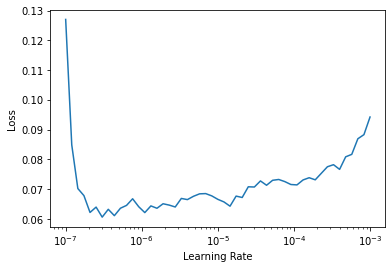

In [38]:
lr_min, _ = learn.lr_find(suggestions=True)
lr_min

Wie zu erwarten war, gibt der Learning Rate Finder einen Vorschlag für eine sehr kleine LR aus. Diese liegt jedoch deutlich unter der typischen Feintuning LR von 2E-5, welche als Standard für die Transformersmodelle verwendet wird. Daher wird abweichend von dem Vorschlagswert 1E-7 eine LR von 2E-5 gewählt.

Nachdem die LR für das Gesamtmodell ermittelt wurde, kann das ganze Modell gefeintuned werden. Die Verwendung der `slice`-Syntax erlaubt es, die unterschiedlichen Layer des Modells mit unterschiedlichen LRs zu trainieren. Der erste Wert wird für den ersten Layer des Modells verwendet und der zweite Wert für den finalen Layer. Die Layer dazwischen erhalten gleichverteilte LR zwischen den beiden Parameterwerten. Dies entspricht der Best Practice Methode `Discriminative Fintuning`. <br>
Das der erste Wert durch 2.6**4 geteilt wird, ist eine Empfehlung aus dem Buch "Deep Learning for Coders with fastai and PyTorch" S.349

In [38]:
learn.fit_one_cycle(4, lr_max = slice(2e-5/2.6**4, 2e-5), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.058581,0.061764,0.979569,0.850037,0.805457,0.827147,03:47
1,0.053356,0.059335,0.980769,0.860883,0.813715,0.836635,03:44
2,0.050175,0.058533,0.980985,0.862752,0.815771,0.838604,03:43
3,0.049042,0.058296,0.981177,0.862378,0.818892,0.840073,03:43


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Der eingebaute Recorder ermöglicht es, den Verlauf der Loss über das Training zu plotten. Diese Visualisierung hilft dabei, den Trainingsverlauf besser nachzuvollziehen. Beispielsweise können so Symptome von Underfitting und Overfitting erkannt werden.

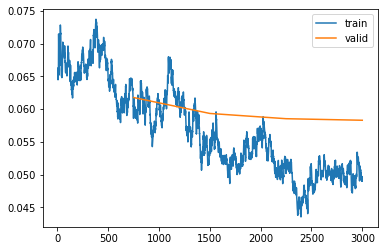

In [39]:
learn.recorder.plot_loss()

Der Plot zeigt keine Anzeichen von Overfitting oder Underfitting.

#### Evaluation des Modells mit dem Testset
Das Modell kann anschließend über die `validate` Methode evaluiert werden. Dafür wird der DataLoader des Testdatensatz übergeben. Als Ausgabe erhält man die berechneten Metriken zurück:

In [40]:
learn.validate(dl=dls_test.valid)

(#5) [0.05972464010119438,0.9811773744358014,0.862378459237098,0.8188920454545454,0.8400728597449909]

Erneutes durchführen des Klassifizierungsreports:

In [41]:
print(learn.token_classification_report)

              precision    recall  f1-score   support

         LOC       0.93      0.89      0.91       801
    LOCderiv       0.91      0.85      0.88       252
     LOCpart       0.52      0.87      0.65        31
         ORG       0.82      0.70      0.76       580
    ORGderiv       0.00      0.00      0.00         0
     ORGpart       0.76      0.72      0.74        96
         OTH       0.69      0.64      0.67       289
    OTHderiv       0.56      0.69      0.62        13
     OTHpart       0.39      0.70      0.50        10
         PER       0.94      0.91      0.92       730
    PERderiv       0.00      0.00      0.00         0
     PERpart       0.39      0.50      0.44        14

   micro avg       0.86      0.82      0.84      2816
   macro avg       0.58      0.62      0.59      2816
weighted avg       0.87      0.82      0.84      2816



Das trainierte Modell schneidet besonders gut in den Hauptkategorien `LOC` und `PER` ab. Die nächstbesten Werte werden für die beiden anderen Hauptkategorien `ORG` und `OTH` erreicht. Dieses Ergebnis entspricht der Erwartung, da es für diese Kategorien auch die meisten Trainingsdaten gab. Besonders für die Klasse der `deriv` Token werden nicht so hohe F1-Werte erreicht. 

#### Speichern des Modells
Das Modell kann über die `export` Methode in einer `.pkl` Datei für die spätere Wiederverwendung gespeichert werden:

In [ ]:
learn.export(fname=f'./models/deepset_finetuned/ner_deepset_fastai.pkl')

### Trainieren eines Modells mit mehr Schritten beim Gradual Unfreezing
In diesem Abschnitt soll getestet werden, ob mit weiteren Unfreezing Schritten eine bessere Modellperformance erreicht werden kann.

In [43]:
# Erzeugen einer neuen Modellinstanz
_, _, _, hf_model2 = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task = task,
                                                                               config_kwargs = config_kwargs )
model2 = HF_BaseModelWrapper(hf_model2)
learn_cbs2 = [HF_BaseModelCallback]

learn2 = Learner(dls_train_valid,
                model2,
                opt_func=partial(Adam),
                cbs=learn_cbs2,
                splitter=hf_splitter)

learn2.create_opt() # -> Erzeugt die Layer Gruppen basierend auf der "splitter" Funktion
# Einfrieren des Modells bis auf den finalen Layer
learn2.freeze()

Nachdem der zweite Learner erzeugt wurde und alle Layer eingefroren wurden kann auch hier die LR gesucht werden:

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.0012022644514217973)

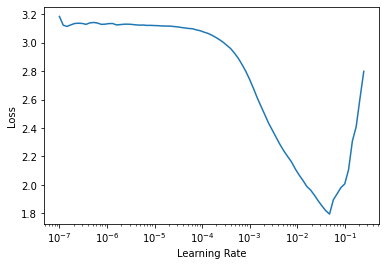

In [44]:
learn2.lr_find()

Der LR-Finder schlägt eine LR von 4E-3 vor. Aus dem Plot geht jedoch hervor, das auch problemlos eine etwas höhere LR gewählt werden kann. Daher wird 1E-2 für den finalen Layer des Modells genutzt.

In [45]:
fit_cbs2 = [HF_TokenClassMetricsCallback()]

Trainieren des gefrorenen Modells mit der ermittelten LR:

In [47]:
learn2.fit_one_cycle(1,lr_max=1e-2, cbs=fit_cbs2)

epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.074151,0.062808,0.979665,0.851159,0.804240,0.827035,02:30


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Auch dieses Modell erreicht nach einer Epoch bereits 97,96 % Accuracy.

Anschließend kann das Modell mit der Methode `freeze_to()` stufenweise unfreezed werden, um immer mehr Parametergruppen zusammen zu trainieren:

In [48]:
learn2.freeze_to(-2)

In [49]:
learn2.blurr_summary()

HF_BaseModelWrapper (Input shape: 32 x 80)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 80 x 768       
Embedding                                 23886336   False     
Embedding                                 393216     False     
Embedding                                 1536       False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     True      
Linear                                    590592     True      
Linear                                    590592     True      
Dropout                                                        
Linear                                    590592     True      
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
      

Dieser Zwischenschritt erlaubt es, vor dem gemeinsamen Training aller Parameter zunächst noch einmal nur 85075225 Parameter des Modells zusammen zu trainieren.

SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=2.75422871709452e-06)

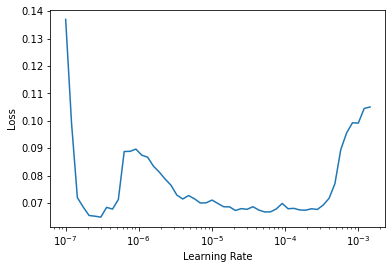

In [50]:
learn2.lr_find()

Da der Learning Rate Finder bei Transformer Modellen eine Tendenz zu sehr kleinen LRs hat, wird eher der Graph zu Ermittlung einer geeigneten LR von mir verwendet. Im zweiten Trainingsschritt werden die entfrorenen Layer mit einer etwas agressiveren LR von 2E-4 (finaler Layer) für eine Epoch trainiert:

In [51]:
learn2.fit_one_cycle(1,lr_max= slice(2e-4/2.6**4,2e-4),cbs=fit_cbs2)

epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.062385,0.057041,0.981634,0.873598,0.831909,0.852244,03:35


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Da es keine weiteren Parametergruppen mehr gibt kann nun das gesamte Modell unfreezed werden. Anschließend wird wieder die LR bestimmt und das Modell für weitere Epochs 3 trainiert.

SuggestedLRs(lr_min=2.0892961765639483e-05, lr_steep=9.77237206711834e-08)

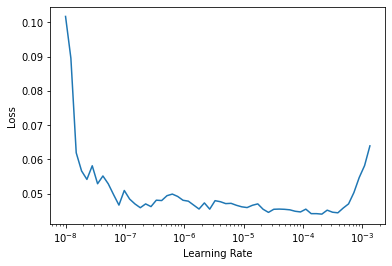

In [52]:
learn2.unfreeze()
learn2.lr_find(start_lr=1e-8)

In [53]:
learn2.fit_one_cycle(3,lr_max = slice(2e-5/2.6**4,2e-5), cbs=fit_cbs2)

epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.037327,0.057549,0.981754,0.876215,0.837683,0.856516,03:46
1,0.038590,0.057356,0.982162,0.882573,0.839858,0.860686,03:44
2,0.038795,0.057550,0.982186,0.881077,0.837540,0.858757,03:44


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Visualisierung des Trainingsverlaufs:

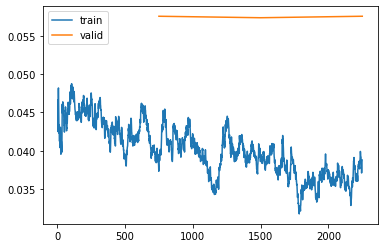

In [54]:
learn2.recorder.plot_loss()

Das weitere Feintuning brachte kaum Verbesserung mit sich. Nach der zweiten Epoch zeigt das Modell eine minimale Tendenz zum Overfitting (die Validation Losskurve nimmt leicht zu)

Übersicht über alle Klassen im Modell:

In [55]:
print(learn2.token_classification_report)

              precision    recall  f1-score   support

         LOC       0.94      0.90      0.92       799
    LOCderiv       0.92      0.87      0.90       247
     LOCpart       0.58      0.79      0.67        38
         ORG       0.85      0.74      0.79       572
    ORGderiv       0.00      0.00      0.00         1
     ORGpart       0.80      0.72      0.76       101
         OTH       0.72      0.68      0.70       285
    OTHderiv       0.62      0.71      0.67        14
     OTHpart       0.61      0.65      0.63        17
         PER       0.95      0.93      0.94       724
    PERderiv       0.00      0.00      0.00         2
     PERpart       0.39      0.54      0.45        13

   micro avg       0.88      0.84      0.86      2813
   macro avg       0.62      0.63      0.62      2813
weighted avg       0.88      0.84      0.86      2813



Evaluation des Modells mit dem Testset:

In [56]:
learn2.validate(dl=dls_test.valid)

(#5) [0.05777420848608017,0.9821857293767406,0.881077038145101,0.8375399928901529,0.8587570621468926]

Im Ergebnis kann festgestellt werden, dass der zusätzliche Schritt beim Graudal Unfreezing Verbesserung der Modellleistung erreichen konnte. Die Best Practice Methoden aus dem UMLFit-Ansatz konnten somit erfolgreich implementiert werden.

In [57]:
learn2.export(fname="ner_deepset_fastai_umlfit")

## Beispielhafte Anwendung des Modells

Um das gespeicherte Modell anzuwenden, muss dieses zunächst mit der Methode `load_learner` geladen werden:

In [58]:
ner = load_learner(fname='ner_deepset_fastai_umlfit')

Anschließend kann `blurr_predict_tokens` verwendet werden, um eine Eingabesequenz zu labeln:
 - dafür muss die Eingabesequenz in einzelne Wort Token zerlegt werden, dies kann mit der `split()` Methode erledigt werden
 - Als Ergebnis erhält man eine Liste aus Tuplen. Diese Tuple enthalten die einzelnen Token, die vorhergesagten Tokenlabel und die Logits pro Token (letzter Hidden State des Modells)

In [59]:
result =ner.blurr_predict_tokens('''Hallo mein Name ist Carsten Bartelt, der Autor dieses Skripts.'''.split())

In [60]:
print(result)

[(['Hallo', 'mein', 'Name', 'ist', 'Carsten', 'Bartelt,', 'der', 'Autor', 'dieses', 'Skripts.'], ['O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O'], tensor([24, 24, 24, 24,  9, 21, 24, 24, 24, 24]), tensor([[1.7882e-03, 9.1801e-05, 4.2508e-05, 2.4169e-03, 2.4589e-05, 2.7956e-05,
         2.6033e-03, 1.8296e-05, 4.2958e-05, 1.0504e-03, 2.4241e-05, 3.5625e-05,
         3.9588e-05, 2.2311e-06, 2.6416e-06, 2.9704e-05, 1.9108e-06, 6.8370e-06,
         1.0379e-04, 9.4562e-06, 1.9144e-06, 1.3529e-04, 2.0662e-06, 7.5515e-06,
         9.9149e-01],
        [9.0622e-06, 2.2549e-05, 2.1463e-05, 4.3392e-06, 6.2582e-06, 1.0930e-05,
         1.4530e-05, 1.4833e-05, 3.3978e-06, 4.7031e-05, 6.5472e-06, 1.1298e-06,
         1.3403e-05, 1.3806e-06, 3.8161e-07, 3.5225e-06, 2.9372e-07, 4.3161e-06,
         2.5321e-04, 2.4057e-06, 2.3312e-06, 4.6902e-05, 6.7535e-07, 1.7018e-06,
         9.9951e-01],
        [5.0103e-07, 5.0824e-07, 9.4941e-07, 3.9847e-06, 3.8796e-07, 1.6032e-06,
         7.3162e-06,

Um die Ausgabe übersichtlicher zu gestalten kann eine eigene `predict_tokens` Methode definiert werden. Diese gibt nur die Tokens und ihre Label aus, welche eine Entität darstellen:

In [62]:
def predict_entities(sequenz):
  result = ner.blurr_predict_tokens(sequenz.split())
  for r in result:
    liste = []
    for i,logit in enumerate(r[3]):
      if r[1][i] != 'O':
        score = logit[torch.argmax(logit)]
        liste.append((r[0][i],r[1][i],f'Score: {score}'))
  return liste

Anschließend kann ein beliebiger String übergeben werden, um die Vorhersage der enthaltenen Enitäten zu erhalten:

In [63]:
predict_entities('''Hallo mein Name ist Carsten Bartelt, der Autor dieses Skripts.''')

[('Carsten', 'B-PER', 'Score: 0.9974938631057739'),
 ('Bartelt,', 'I-PER', 'Score: 0.9982329607009888')]

In [64]:
predict_entities('''In der CDU liegen die Nerven blank. Parteichef Laschet und andere führende Christdemokraten sprechen
    nach den Niederlagen in Mainz und Stuttgart von einem Warnschuss – und attackieren die SPD. ''')

[('CDU', 'B-ORG', 'Score: 0.9951028823852539'),
 ('Laschet', 'B-PER', 'Score: 0.9969385862350464'),
 ('Mainz', 'B-LOC', 'Score: 0.9948015213012695'),
 ('Stuttgart', 'B-LOC', 'Score: 0.9950716495513916'),
 ('SPD.', 'B-ORG', 'Score: 0.9900239109992981')]

In [65]:
predict_entities('''Die Europäische Union hat ein Verfahren gegen Großbritannien wegen Verletzung des EU-Austrittsvertrags
    eingeleitet. Dies teilte die EU-Kommission am Montag in Brüssel mit. ''')

[('Europäische', 'B-ORG', 'Score: 0.98826664686203'),
 ('Union', 'I-ORG', 'Score: 0.986423909664154'),
 ('Großbritannien', 'B-LOC', 'Score: 0.9967671632766724'),
 ('EU-Austrittsvertrags', 'B-ORGpart', 'Score: 0.9837468266487122'),
 ('EU-Kommission', 'B-ORGpart', 'Score: 0.7402018308639526'),
 ('Brüssel', 'B-LOC', 'Score: 0.9480343461036682')]

In [66]:
predict_entities('''Das sogenannte Nordirland-Protokoll im Austrittsvertrag sieht vor,
    dass einige Regeln des EU-Binnenmarkts für Nordirland weiter gelten.
    Dies soll Kontrollen an der Landgrenze zum EU-Staat Irland auf der gemeinsamen
    Insel überflüssig machen. Da Waren dennoch kontrolliert werden müssen, um EU-Standards zu wahren,
    wurden die Kontrollen auf Häfen an der Irischen See zwischen Nordirland und dem übrigen
    Großbritannien verschoben. So wurde das Problem zwischen Großbritannien und der
    EU – und insbesondere der europäischen Republik Irland – zu einem innerbritischen Problem.''')

[('Nordirland-Protokoll', 'B-LOCpart', 'Score: 0.6158080697059631'),
 ('EU-Binnenmarkts', 'B-ORGpart', 'Score: 0.9675512313842773'),
 ('Nordirland', 'B-LOC', 'Score: 0.9979050159454346'),
 ('EU-Staat', 'B-ORGpart', 'Score: 0.9932492971420288'),
 ('Irland', 'B-LOC', 'Score: 0.9985442161560059'),
 ('EU-Standards', 'B-ORGpart', 'Score: 0.9735710024833679'),
 ('Irischen', 'B-LOCderiv', 'Score: 0.7378007173538208'),
 ('See', 'I-LOC', 'Score: 0.7965312004089355'),
 ('Nordirland', 'B-LOC', 'Score: 0.997840166091919'),
 ('Großbritannien', 'B-LOC', 'Score: 0.9988467693328857'),
 ('Großbritannien', 'B-LOC', 'Score: 0.9963253140449524'),
 ('EU', 'B-ORG', 'Score: 0.9639769196510315'),
 ('europäischen', 'B-LOCderiv', 'Score: 0.8143371343612671'),
 ('Irland', 'B-LOC', 'Score: 0.993513822555542'),
 ('innerbritischen', 'B-LOCderiv', 'Score: 0.9044633507728577')]

In [67]:
predict_entities('''@_A_K_K_ @CDU @jensspahn @_FriedrichMerz Die CDU muss für den packt und die betrügerische
    Wahl karrenbauer muss absteigen auf 12% Überall sind die Regierungen gegen den packt Deutschland
    wird von irren in den Abgrund gerissen.''')

[('CDU', 'B-ORG', 'Score: 0.979066789150238'),
 ('Deutschland', 'B-LOC', 'Score: 0.9931319355964661')]

Das Modell scheint im Gegensatz zu denen die der `Transformers`- Bibliothek trainiert wurden keine Entitäten zu erkennen wenn diese Twitter-typische `@` Symbole vor dem Namen haben:

In [68]:
predict_entities("@Portugal @Angela_Merkel @SPD @Europäische_Union")

[]

In [69]:
predict_entities("Portugal Angela_Merkel SPD Europäische_Union")

[('Portugal', 'B-LOC', 'Score: 0.9593344926834106'),
 ('Angela_Merkel', 'B-PER', 'Score: 0.8605829477310181'),
 ('SPD', 'B-ORG', 'Score: 0.8843768239021301'),
 ('Europäische_Union', 'B-ORG', 'Score: 0.8845838904380798')]

In [70]:
predict_entities("$Portugal $Angela_Merkel $SPD $Europäische_Union")

[]